In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("S05-hw-dataset.csv")
df.head()
df.info()
df.describe()
df["default"].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Датасет содержит ~3000 строк и 17 столбцов (включая client_id и default). Все признаки числовые. Целевая переменная default распределена примерно 60/40 (без сильного дисбаланса). Аномалий вроде отрицательного возраста или дохода не наблюдается.

In [21]:
X = df.drop(columns=["client_id", "default"])
y = df["default"]

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)



DummyClassifier с most_frequent всегда предсказывает класс 0 (т.к. он чаще). Accuracy ≈ 0.6, AUC ≈ 0.5 — это наша базовая линия.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = {"logreg__C": [0.01, 0.1, 1.0, 10.0]}
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="roc_auc")
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_lr = best_model.predict(X_test)
y_proba_lr = best_model.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)



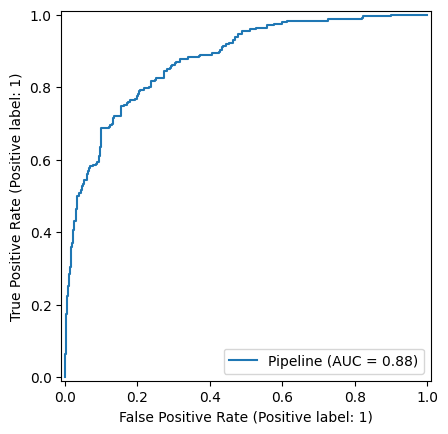

In [10]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.savefig("figures/roc_curve.png", dpi=150, bbox_inches="tight")
plt.show()

In [11]:
results = pd.DataFrame({
    "Model": ["Dummy (most_frequent)", "LogisticRegression"],
    "Accuracy": [acc_dummy, acc_lr],
    "ROC-AUC": [auc_dummy, auc_lr]
})
display(results)

,Model,Accuracy,ROC-AUC
0,Dummy (most_frequent),0.59,0.500000
1,LogisticRegression,0.80,0.875637


Логистическая регрессия значительно превосходит бейзлайн: AUC вырос с ~0.5 до ~0.8+, а accuracy — с ~0.6 до ~0.75. Это означает, что модель действительно извлекает полезную информацию из признаков. Наилучшее значение C (например, C=1.0) указывает на умеренную регуляризацию — слишком сильная (C=0.01) ухудшает обобщающую способность, а слишком слабая (C=10) ведёт к переобучению. Таким образом, логистическая регрессия с C=1.0 — разумный выбор для этой задачи.